In [ ]:
import os
import re
import time
import json
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import random
from torch_geometric.data import Data
import pybullet as p
import pybullet_data
import trimesh
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict, Counter

import roboticstoolbox as rtb
from core.sim.utils import (
    Camera, PyBulletSim, load_object_urdf, load_table_urdf, get_bounding_box_size,
)
from core.sim.robot_manager import RobotController

# Workspace

In [ ]:
# Add import for plotly
import plotly.graph_objects as go

def visualize_workspace_3d_interactive(robot, x_range, y_range, z_heights, table_size, table_z, grid_resolution=6):
    """
    Create an interactive 3D visualization of robot workspace showing TRUE reachability.
    Uses the robot's actual move_end_effector method to physically test each point.
    This is the GROUND TRUTH method for reachability testing.
    """
    
    # Calculate ranges
    x_range_size = x_range[1] - x_range[0]  # 1.0m
    y_range_size = y_range[1] - y_range[0]  # 1.0m  
    z_min, z_max = min(z_heights), max(z_heights)
    z_range_size = z_max - z_min
    
    # Create grids with uniform density (points per meter)
    x_points = np.linspace(x_range[0], x_range[1], grid_resolution)
    y_points = np.linspace(y_range[0], y_range[1], grid_resolution)
    
    # Z-axis gets proportionally fewer points based on its smaller range
    z_resolution = max(2, int(grid_resolution * 1.5 * z_range_size / x_range_size))  # At least 2 points
    z_points = np.linspace(z_min, z_max, z_resolution)
    
    all_reachable_points = []
    all_unreachable_points = []
    
    # Fixed head-down orientation for grasping
    head_down_orientation = [-np.pi, 0, 0]
    
    print(f"X: {len(x_points)} points from {x_range[0]:.3f} to {x_range[1]:.3f}m (range: {x_range_size:.3f}m)")
    print(f"Y: {len(y_points)} points from {y_range[0]:.3f} to {y_range[1]:.3f}m (range: {y_range_size:.3f}m)") 
    print(f"Z: {len(z_points)} points from {z_min:.3f} to {z_max:.3f}m (range: {z_range_size:.3f}m)")
    print(f"Total points to test: {len(x_points) * len(y_points) * len(z_points)}")
    print(f"Point density: ~{grid_resolution/x_range_size:.1f} points/meter")
    print(f"Using orientation: [{head_down_orientation[0]:.3f}, 0, 0]")
    
    # Store initial state to reset after each test
    initial_joint_positions = [robot.joints[i].get_position() for i in range(7)]
    initial_ee_pos, initial_ee_orn = robot.get_ee_pos()
    
    print(f"Robot initial position: [{initial_ee_pos[0]:.3f}, {initial_ee_pos[1]:.3f}, {initial_ee_pos[2]:.3f}]")
    robot_base_pos, _ = p.getBasePositionAndOrientation(robot.robot_id)
    print(f"Robot base position: [{robot_base_pos[0]:.3f}, {robot_base_pos[1]:.3f}, {robot_base_pos[2]:.3f}]")
    
    # Create list of all points to test for tqdm
    all_test_points = []
    for z_height in z_points:
        for x in x_points:
            for y in y_points:
                all_test_points.append([x, y, z_height])
    
    # Test all points with proper progress bar
    for target_pos in tqdm(all_test_points, desc="Testing reachability"):
        try:
            # Reset robot to initial state before each test
            robot.reset_joints(initial_joint_positions)
            
            # Move to initial position first (to ensure consistent starting point)
            robot.move_end_effector(initial_ee_pos, p.getEulerFromQuaternion(initial_ee_orn))
            
            # Try to move robot to target position using move_end_effector method
            robot.move_end_effector(target_pos, head_down_orientation)
            
            # Check if robot actually reached the target position and orientation
            actual_ee_pos, actual_ee_orn = robot.get_ee_pos()
            actual_ee_euler = p.getEulerFromQuaternion(actual_ee_orn)
            
            # Calculate position error
            pos_error = np.linalg.norm(np.array(actual_ee_pos) - np.array(target_pos))
            
            # Calculate orientation error (handle both pi and -pi representations)
            orn_error = min(
                np.linalg.norm(np.array(actual_ee_euler) - np.array(head_down_orientation)),
                np.linalg.norm(np.array(actual_ee_euler) - np.array([np.pi, 0, 0]))
            )
            
            # Check if both position and orientation are acceptable
            if pos_error < 0.05 and orn_error < 0.2:  # More lenient tolerances
                all_reachable_points.append(target_pos)
                # print(f"✓ REACHABLE: [{target_pos[0]:.3f}, {target_pos[1]:.3f}, {target_pos[2]:.3f}] (pos_err: {pos_error:.3f}m, orn_err: {orn_error:.3f}rad)")
            else:
                all_unreachable_points.append(target_pos)
                # print(f"✗ UNREACHABLE: [{target_pos[0]:.3f}, {target_pos[1]:.3f}, {target_pos[2]:.3f}] (pos_err: {pos_error:.3f}m, orn_err: {orn_error:.3f}rad)")
                
        except Exception as e:
            # Movement failed - point is unreachable
            all_unreachable_points.append(target_pos)
            print(f"✗ FAILED: [{target_pos[0]:.3f}, {target_pos[1]:.3f}, {target_pos[2]:.3f}] - Exception: {str(e)[:50]}...")
            
            # Reset robot after failure
            try:
                robot.reset_joints(initial_joint_positions)
            except:
                pass
    
    # Reset robot to initial state
    robot.reset_joints(initial_joint_positions)
    
    # Convert to numpy arrays
    all_reachable_points = np.array(all_reachable_points) if all_reachable_points else np.empty((0, 3))
    all_unreachable_points = np.array(all_unreachable_points) if all_unreachable_points else np.empty((0, 3))
    
    # Create interactive 3D plot
    fig = go.Figure()
    
    # Add reachable points (green)
    if len(all_reachable_points) > 0:
        fig.add_trace(go.Scatter3d(
            x=all_reachable_points[:, 0],
            y=all_reachable_points[:, 1],
            z=all_reachable_points[:, 2],
            mode='markers',
            marker=dict(size=8, color='green', opacity=0.9),
            name='Reachable Points',
            hovertemplate='<b>REACHABLE</b><br>X: %{x:.3f}m<br>Y: %{y:.3f}m<br>Z: %{z:.3f}m<extra></extra>'
        ))
    
    # Add unreachable points (red, same size)
    if len(all_unreachable_points) > 0:
        fig.add_trace(go.Scatter3d(
            x=all_unreachable_points[:, 0],
            y=all_unreachable_points[:, 1],
            z=all_unreachable_points[:, 2],
            mode='markers',
            marker=dict(size=8, color='red', opacity=0.9),
            name='Unreachable Points',
            hovertemplate='<b>UNREACHABLE</b><br>X: %{x:.3f}m<br>Y: %{y:.3f}m<br>Z: %{z:.3f}m<extra></extra>'
        ))
    
    # Add robot base position
    robot_base_pos, _ = p.getBasePositionAndOrientation(robot.robot_id)
    fig.add_trace(go.Scatter3d(
        x=[robot_base_pos[0]],
        y=[robot_base_pos[1]], 
        z=[robot_base_pos[2]],
        mode='markers',
        marker=dict(size=15, color='blue', symbol='diamond'),
        name='Robot Base',
        hovertemplate=f'<b>Robot Base</b><br>X: {robot_base_pos[0]:.3f}m<br>Y: {robot_base_pos[1]:.3f}m<br>Z: {robot_base_pos[2]:.3f}m<extra></extra>'
    ))
    
    # Add table surface
    table_width, table_height = table_size
    table_x = [-table_width/2, table_width/2, table_width/2, -table_width/2, -table_width/2]
    table_y = [-table_height/2, -table_height/2, table_height/2, table_height/2, -table_height/2]
    table_z_line = [table_z] * 5
    
    fig.add_trace(go.Scatter3d(
        x=table_x, y=table_y, z=table_z_line,
        mode='lines',
        line=dict(color='brown', width=10),
        name='Table Edge'
    ))
    
    # Add table surface mesh
    fig.add_trace(go.Mesh3d(
        x=[-table_width/2, table_width/2, table_width/2, -table_width/2],
        y=[-table_height/2, -table_height/2, table_height/2, table_height/2],
        z=[table_z, table_z, table_z, table_z],
        i=[0, 0], j=[1, 2], k=[2, 3],
        color='brown', opacity=0.3, name='Table Surface'
    ))
    
    # Update layout with uniform aspect ratio
    fig.update_layout(
        title=f'Robot GROUND TRUTH Reachability (move_end_effector Test)<br>Base at [{robot_base_pos[0]:.3f}, {robot_base_pos[1]:.3f}, {robot_base_pos[2]:.3f}] - {len(x_points)}×{len(y_points)}×{len(z_points)} grid',
        scene=dict(
            xaxis_title='X (m)', 
            yaxis_title='Y (m)', 
            zaxis_title='Z (m)',
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.5)),
            aspectmode='manual',  # Manual aspect ratio control
            aspectratio=dict(x=1, y=1, z=z_range_size/x_range_size)  # Scale Z relative to X
        ),
        width=900, height=700
    )
    
    fig.show()
    
    # Print detailed statistics
    total_points = len(all_reachable_points) + len(all_unreachable_points)
    if total_points > 0:
        reachability = len(all_reachable_points) / total_points * 100
        print(f"\nGROUND TRUTH Reachability Results (move_end_effector Test):")
        print(f"Total sampled points: {total_points}")
        print(f"Reachable points: {len(all_reachable_points)}")
        print(f"Unreachable points: {len(all_unreachable_points)}")
        print(f"Overall reachability: {reachability:.1f}%")
        
        if len(all_reachable_points) > 0:
            # Distance analysis
            robot_base_pos_2d = [-0.6, 0]
            distances = np.linalg.norm(all_reachable_points[:, :2] - robot_base_pos_2d, axis=1)
            print(f"Maximum reach: {np.max(distances):.3f}m")
            print(f"Mean reach: {np.mean(distances):.3f}m")
            print(f"Minimum reach: {np.min(distances):.3f}m")
    
    return all_reachable_points, all_unreachable_points

# Usage - Test GROUND TRUTH robot reachability in stationary mode:
sim = PyBulletSim(p.DIRECT)
table = load_table_urdf((100, 100))
z = get_bounding_box_size(table)[2]

# Test table area (points above the table)
x_range, y_range = [-0.5, 0.5], [-0.5, 0.5]

# Create robot in stationary mode with CORRECT initialization
robot = RobotController("franka_panda/panda.urdf", rtb.models.Panda(), 
                       scale=1.5, initial_base_pos=[-0.7, 0, z], mode='stationary')

# Test 20cm above table surface (as requested)
z_heights = [z+0.01, z+0.41]
table_size = (1.0, 1.0)

# Grid resolution - Z will automatically get fewer points due to smaller range
print("Testing GROUND TRUTH reachability using move_end_effector method...")
reachable_points, unreachable_points = visualize_workspace_3d_interactive(
    robot, x_range, y_range, z_heights, table_size, z, grid_resolution=10
)

sim.close()

# Simulation

Loading specific rearrangement: rearrangement_00014
Scene ID: 14
Number of objects: 4
Grid size: [100, 100]
Using default object sizes
Manipulator at [49, 49]


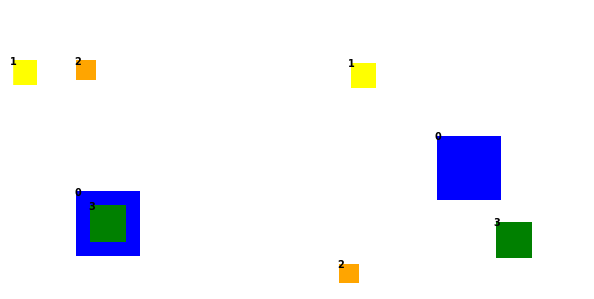

--------Labbe_S--------
plan: [5670, 29427, 12332, 38286]
elapsed_time: 0.015s
steps: 10
Moved 0 to: [56 58] | cost: 0.821 | done: False
Moved 2 to: [94 15] | cost: 1.412 | done: False
Moved 1 to: [23 20] | cost: 1.089 | done: False
Moved 3 to: [82 74] | cost: 1.423 | done: True
episode cost: 4.745


In [ ]:
from core.env.scene_manager import SceneManager
from core.env.scene_utils import scene_meta_to_x
from core.planners.utils import evaluate_alg
from core.planners.Labbe import Labbe_S

def load_rearrangement_meta(dataset_dir: str="dataset", scene_id: int=None) -> dict:
    """
    Load a rearrangement meta file either by scene ID or randomly.
    
    Args:
        dataset_dir: Path to the dataset directory
        scene_id: Optional scene ID to load specific rearrangement. If None, loads randomly.
        
    Returns:
        Dictionary containing the rearrangement metadata
    """
    if not os.path.exists(dataset_dir):
        raise FileNotFoundError(f"Dataset directory '{dataset_dir}' does not exist")
    
    # Find all rearrangement directories
    rearrangement_dirs = [
        item for item in os.listdir(dataset_dir) 
        if os.path.isdir(os.path.join(dataset_dir, item)) and item.startswith('rearrangement_')
    ]
    
    if not rearrangement_dirs:
        raise FileNotFoundError(f"No rearrangement directories found in '{dataset_dir}'")
    
    if scene_id is not None:
        # Load specific scene ID
        target_dir = f"rearrangement_{scene_id:05d}"
        if target_dir not in rearrangement_dirs:
            raise FileNotFoundError(f"Rearrangement with scene ID {scene_id} not found")
        selected_dir = target_dir
        print(f"Loading specific rearrangement: {selected_dir}")
    else:
        # Randomly select one directory
        selected_dir = random.choice(rearrangement_dirs)
        print(f"Loading random rearrangement: {selected_dir}")
    
    meta_file_path = os.path.join(dataset_dir, selected_dir, 'meta.json')
    
    if not os.path.exists(meta_file_path):
        raise FileNotFoundError(f"meta.json not found in {selected_dir}")
    
    # Load and return the meta file
    with open(meta_file_path, 'r') as f:
        meta_data = json.load(f)
    
    return meta_data

dataset_dir = 'temp'
meta_data = load_rearrangement_meta(dataset_dir, scene_id=14)
# meta_data = load_rearrangement_meta(dataset_dir, scene_id=902)

scene_id = meta_data['scene_id']
folder_name = f'rearrangement_{scene_id:05d}'
folder_path = os.path.join(dataset_dir, folder_name)

print(f"Scene ID: {meta_data.get('scene_id', 'Unknown')}")
print(f"Number of objects: {meta_data.get('num_objects', 'Unknown')}")
print(f"Grid size: {meta_data.get('grid_size', 'Unknown')}")

initial_x, target_x = scene_meta_to_x(meta_data)
env = SceneManager(
    num_objects=meta_data['num_objects'],
    grid_size=tuple(meta_data['grid_size'])
)
env.reset(initial_scene=initial_x, target_scene=target_x)
env.render(fig_size=3)

plan = evaluate_alg(env, Labbe_S, initial_x, target_x)

In [3]:
from core.sim.robot_manager import RobotController

def load_objects_from_labels(folder_path):
    """
    Load objects from both initial and target labels files, combining all information.
    
    Args:
        folder_path: Path to the folder containing initial_labels.json and target_labels.json

    Returns:
        List of object dictionaries with complete initial and target information
    """
    initial_label_path = os.path.join(folder_path, 'initial_labels.json')
    target_label_path = os.path.join(folder_path, 'target_labels.json')
    
    if not os.path.exists(initial_label_path):
        raise FileNotFoundError(f"Initial labels file not found: {initial_label_path}")
    
    if not os.path.exists(target_label_path):
        raise FileNotFoundError(f"Target labels file not found: {target_label_path}")
    
    # Load initial labels
    with open(initial_label_path, 'r') as f:
        initial_labels = json.load(f)
    
    # Load target labels
    with open(target_label_path, 'r') as f:
        target_labels = json.load(f)
    
    # Create dictionary indexed by obj_id for target labels
    target_dict = {label['obj_id']: label for label in target_labels}
    
    objects = []
    # Process each object from initial labels
    for initial_obj in initial_labels:
        obj_id = initial_obj['obj_id']
        model_name = initial_obj['model_name']
        model_id = initial_obj['model_id']
        body_type = int(model_id.split('_')[-1])

        # Extract initial 6D pose
        initial_pose_6d = initial_obj['6D_pose']
        initial_pos = initial_pose_6d[:3]  # x, y, z position
        initial_orn = initial_pose_6d[3:]  # roll, pitch, yaw orientation
        
        # Load object with initial pose
        body_id, _ = load_object_urdf(model_name, initial_pos, initial_orn, body_type=body_type)
        
        # Get initial base_id
        initial_base_id = None
        if initial_obj['natural_parent_list']:
            initial_base_id = initial_obj['natural_parent_list'][0]
        
        # Get target information
        target_obj = target_dict.get(obj_id)
        if target_obj is None:
            raise ValueError(f"Object {obj_id} found in initial labels but not in target labels")
        
        # Extract target 6D pose
        target_pose_6d = target_obj['6D_pose']
        target_pos = target_pose_6d[:3]
        target_orn = target_pose_6d[3:]
        
        # Get target base_id
        target_base_id = None
        if target_obj['natural_parent_list']:
            target_base_id = target_obj['natural_parent_list'][0]
        
        # Create complete object dictionary
        objects.append({
            'object_id': obj_id,
            'model_name': model_name,
            'body_id': body_id,
            'body_type': body_type,
            'initial_pos': initial_pos,
            'initial_orn': initial_orn,
            'initial_base_id': initial_base_id,
            'initial_bbox': initial_obj['bbox'],
            'target_pos': target_pos,
            'target_orn': target_orn,
            'target_base_id': target_base_id,
            'target_bbox': target_obj['bbox']
        })

    # Sort by object_id to maintain consistent ordering
    objects.sort(key=lambda x: x['object_id'])
    
    print(f"Loaded {len(objects)} objects with complete initial and target information")
    
    return objects

# sim = PyBulletSim(p.GUI)
# # sim = PyBulletSim(p.DIRECT)
# table = load_table_urdf((100, 100))
# z = get_bounding_box_size(table)[2]
# cam = Camera(target_pos=[0.6, 0, 1.5], distance=0.5, yaw=90, pitch=-40, roll=0)

# robot = RobotController("franka_panda/panda.urdf", rtb.models.Panda(), 
#               scale=1.4, initial_base_pos=[-0.7, 0, z], mode='stationary')
# init_pos = robot.get_ee_pos()[0]

# objects = load_objects_from_labels(folder_path)

# robot.move_to_position(init_pos)

# sim.close()

Loaded 4 objects with complete initial and target information
Manipulator at [49, 49]


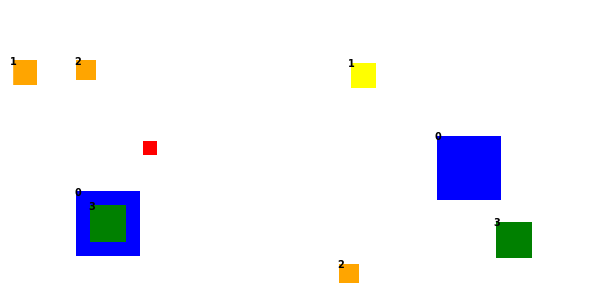

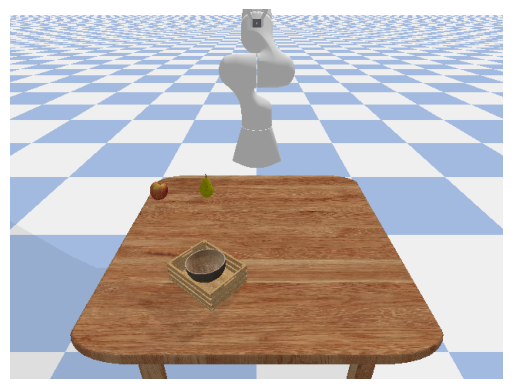

Moved 0 to: [56 58] | cost: 0.821 | done: False
Manipulator at [56, 58]


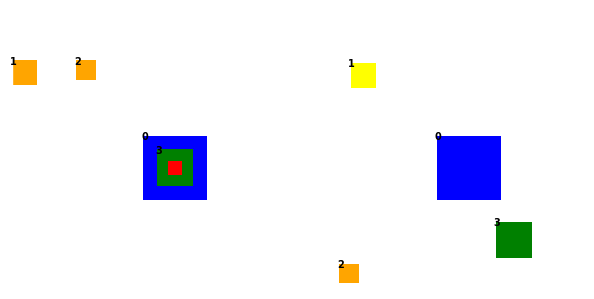

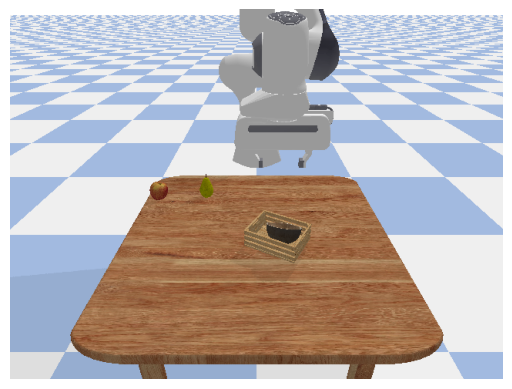

Moved 2 to: [94 15] | cost: 1.412 | done: False
Manipulator at [94, 15]


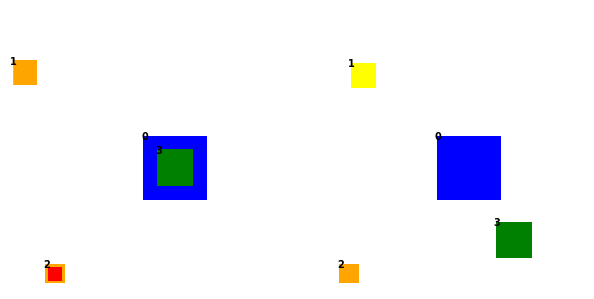

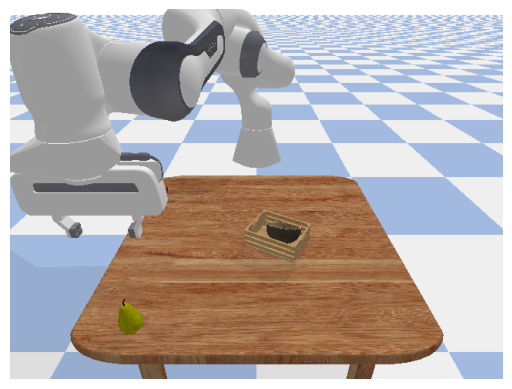

Moved 1 to: [23 20] | cost: 1.089 | done: False
Manipulator at [23, 20]


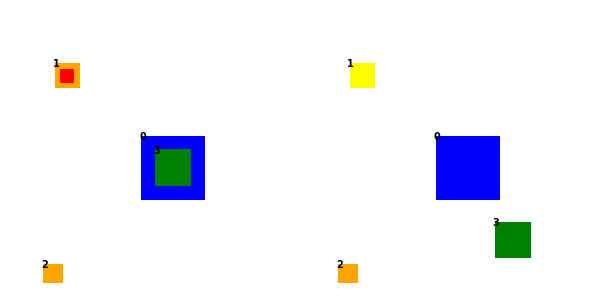

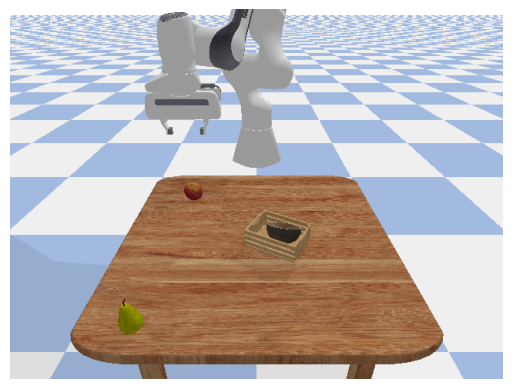

Moved 3 to: [82 74] | cost: 1.423 | done: True
Manipulator at [49, 49]


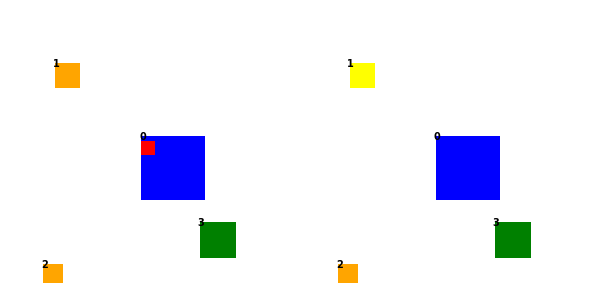

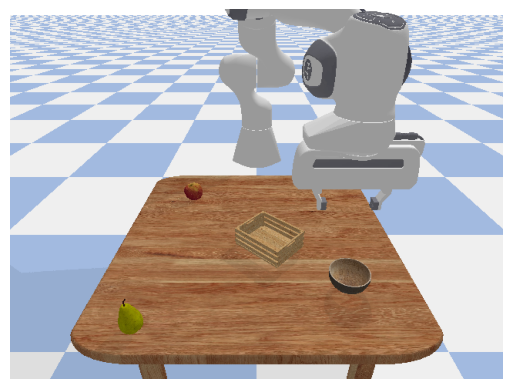

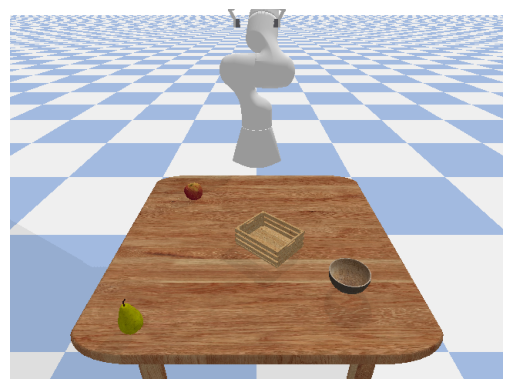

In [ ]:
def map_position(pos, x_range, y_range, grid_scale=0.01):
	x, y = pos

	# Map x
	new_x_min, new_x_max = x_range
	new_x = x * grid_scale * (new_x_max - new_x_min) + new_x_min

	# Map y
	new_y_min, new_y_max = y_range
	new_y = y * grid_scale * (new_y_max - new_y_min) + new_y_min

	return new_x, new_y

# sim = PyBulletSim(p.GUI)
sim = PyBulletSim(p.DIRECT)
table = load_table_urdf((100, 100))
z = get_bounding_box_size(table)[2]
cam = Camera(target_pos=[0.6, 0, 1.3], distance=0.5, yaw=90, pitch=-30, roll=0)

robot = RobotController("franka_panda/panda.urdf", rtb.models.Panda(), 
              scale=1.5, initial_base_pos=[-0.7, 0, z], mode='stationary')
init_pos = robot.get_ee_pos()[0]

objects = load_objects_from_labels(folder_path)

env.reset(initial_x, target_x)
env.render(show_manipulator=True, fig_size=3)
cam.show_img(cam.capture_image())

for action in plan:
	action_type, obj_idx1, obj_idx2, pos_2d = env.decode_action(action)
	env._step(action_type, obj_idx1, obj_idx2, pos_2d, log=True)
	env.render(show_manipulator=True, fig_size=3)

	if action_type == 'move':
		body_id = objects[obj_idx1]['body_id']
		initial_orn = objects[obj_idx1]['initial_orn']
		target_pos = objects[obj_idx1]['target_pos']
		target_orn = objects[obj_idx1]['target_orn']
		obj = objects[0]
		robot.pick_object(body_id, initial_orn[2])
		robot.place_object(target_pos, target_yaw=target_orn[2])
		cam.show_img(cam.capture_image())
	# elif action_type == 'stack':
	# 	print(f"Action: Stack object {obj_idx1} on object {obj_idx2}")

robot.move_to_position(init_pos)
cam.show_img(cam.capture_image())

sim.close()

# Detection

In [ ]:
import pathlib
pathlib.PosixPath = pathlib.WindowsPath

model_path = f'perception/final_yolov5l/weights/best.pt'
model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path, force_reload=True, device='cpu')

In [ ]:
img_unseen = Image.open(f"dataset/rearrangement_00001/initial_image.png")
results = model(img_unseen)
# results.pandas().xyxy
results.show()

# Simulation

In [6]:
from core.sim.utils import (
    Camera, PyBulletSim, load_object_urdf, load_table_urdf, get_bounding_box_size, random_tilt
)

def random_pos(x_range, y_range, z_range):
    return [
        random.uniform(*x_range),
        random.uniform(*y_range),
        random.uniform(*z_range)
    ]

sim = PyBulletSim(p.GUI)
# sim = PyBulletSim(p.DIRECT)
cam = Camera(target_pos=[0.5, 0, 1], distance=0.1, yaw=90, pitch=-40, roll=0)
p.configureDebugVisualizer(p.COV_ENABLE_GUI, 0)
table = load_table_urdf((100, 100))
z = get_bounding_box_size(table)[2]
load_object_urdf('basket', [0.3, -0.15, z+0.05], body_type=3, use_fixed_base=True)
# mug_orn = [0, 0, random.uniform(0, 2 * np.pi)]
mug_orn = [0, 0, np.pi/1.5]
load_object_urdf('mug',    [0.3, -0.15, z+0.1], mug_orn, body_type=3)
pos, orn = [0.3, -0.15, z+0.2], [np.pi / 2, 0, 0]
pos, orn = random_tilt(pos, orn, max_shift=0.01, tilt_angle=10)
load_object_urdf('spoon',  pos, orn)

# sim.step(20)
load_object_urdf('mug',    [0.3, 0.15, z+0.08], mug_orn, body_type=3)
load_object_urdf('spoon',  pos+[0, 0.3, 0], orn)
sim.close()